## GradCAM for the VGG-like network

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib.cm as cm

In [2]:
subset = np.load("../data/simimgs.npy")
subset = subset[:, :, :, 0, :, : , :, :, :]
# (5, 3, 3, 1, 32, 5, 24, 64, 64)
subset = subset.reshape(-1, 64, 64)

# agumentation
xprime = np.zeros_like(subset)
for i in range(subset.shape[0]):
    xnew = subset[i]  + 0.1*np.std(subset[i])* np.random.random( (64, 64) )
    xnew = (np.log10(xnew) - np.log10(xnew.max()) + 2.) / 2.
    xprime[i] = xnew 
xprime[xprime < 0] = 0
subset = xprime
subset = subset.reshape(5, 3, 3, 32, 5, 24, 64, 64)

In [4]:
img_size = (64, 64)
#last_conv_layer_name = "conv2d_5"
last_conv_layer_name = "conv2d_3"
#last_conv_layer_name = "max_pooling2d_1"
classifier_layer_names = [
    "max_pooling2d_1",
    "conv2d_4",
    "conv2d_5",
    "max_pooling2d_2",
    "flatten",
    "dense",
    "dropout",
    "dense_1",
    "dropout_1",
    "dense_2",
    "dropout_2",
    "dense_3"
]

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [5]:
model = tf.keras.models.load_model("../models/VGG_like/model")

/Users/shjzhang/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: The following kwargs were not used by contour: 'rasterized'


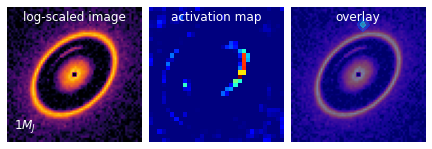

In [8]:
img_array = subset[None, 3, 0, 1, 0, 3, 3, :, :, None]
heatmap = make_gradcam_heatmap(
            img_array, model, last_conv_layer_name, classifier_layer_names)

plt.rc("font", size=12)
plt.figure(figsize = (7.5, 3))
plt.subplot(131)

plt.imshow(img_array[0,:,:,0], extent=(0, 31,0, 31), origin='lower', cmap='inferno', vmax=1.1)
plt.text(0.5, 0.9, "log-scaled image", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
plt.text(0.05, 0.1, r"1$M_J$", transform=plt.gca().transAxes, color='w', horizontalalignment='left')
plt.axis('off')
plt.subplot(132)
plt.imshow(heatmap, cmap='jet', origin="lower")
plt.text(0.5, 0.9, "activation map", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
plt.axis('off')

plt.subplot(133)
plt.contourf(heatmap, alpha=0.5, cmap='jet', rasterized=True)
plt.text(0.5, 0.9, "overlay", transform=plt.gca().transAxes, color='w', horizontalalignment='center')

plt.imshow(img_array[0,:,:,0], extent=(0, 31,0, 31), origin='lower', cmap='inferno')
plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)
    #plt.savefig("gradcam.pdf", bbox_inches='tight', transparent=True)